In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def create_output_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)
        print(f"Folder created: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

objects_folder = "./output"
create_output_folder(objects_folder)


Folder already exists: ./output


In [3]:
# to ensure that text in plt images opens as text box rather than glyphs in adobe
plt.rcParams['pdf.fonttype'] = 42  
plt.rcParams['ps.fonttype'] = 42   

In [4]:
adata = sc.read_h5ad('../nucseq_outs/adata_Nuc.h5ad')

In [5]:
sample_rename_map = {
    "nP103K": "P01",
    "nP108K": "P02",
    "nP126K": "P03",
    "nP137K": "P04",
    "nP139K": "P05",
    "nP143K": "P06",
    "nP072K": "P07",
    "nP073K": "P08",
    "nP105K": "P09",
    "nP140K": "P10",
    "nP144K": "P11",
    "nCN017K": "C02",
    "nCN029K": "C01",
    "nCN021K": "C03",
    "nC018K": "C04",
    }

adata.obs["sample_ids"] = adata.obs["sample"].map(sample_rename_map)
sample_order = [
    "P01",
    "P02",
    "P03",
    "P04",
    "P05",
    "P06",
    "P07",
    "P08",
    "P09",
    "P10",
    "P11",
    "C01",
    "C02",
    "C03",
    "C04"
]

adata.obs["sample_ids"] = pd.Categorical(
    adata.obs["sample_ids"],  
    categories=sample_order,
    ordered=True
)

In [6]:
adata.obs.celltype_l1.replace({"endothelial cell": "EC",
                                "parietal epithelial cell": "PEC",
                               "MAC-M2" : "MAC",
                               'mesangial cell':'MC',
                               'podocyte': 'POD',
                              }, inplace=True)

In [7]:
#Metrics
num_nuclei = adata.n_obs
median_genes = adata.obs["n_genes_by_counts"].median()
median_transcripts = adata.obs["total_counts"].median()

print(f'number of nuclei:',num_nuclei)
print(f'median number of genes:',median_genes)
print(f'median number of transcripts:',median_transcripts)


number of nuclei: 136376
median number of genes: 932.0
median number of transcripts: 1234.0


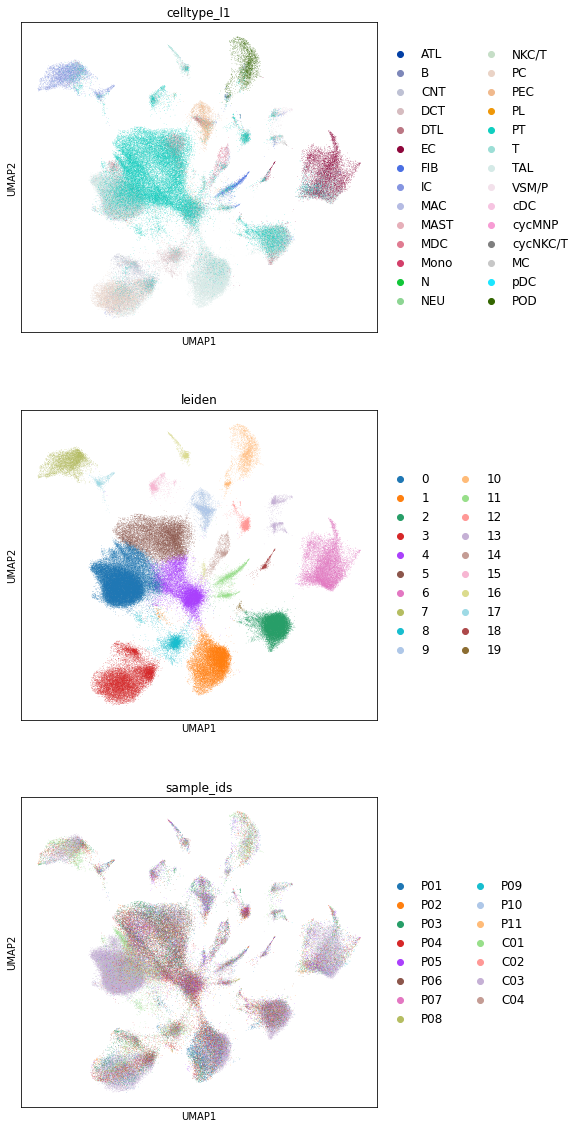

In [8]:
plt.rcParams["figure.figsize"] = (6, 6) 

sc.pl.umap(
    adata,
    color=['celltype_l1', 'leiden', 'sample_ids'],
    ncols=1, 
    legend_fontsize=12,
    legend_fontoutline=2
)


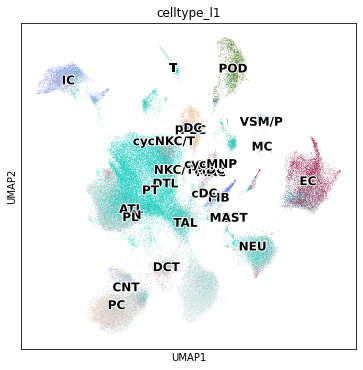

In [9]:
plt.rcParams["figure.figsize"] = (6, 6) 

sc.pl.umap(
    adata,
    color=['celltype_l1'],
    legend_loc='on data',
    legend_fontsize=12,
    legend_fontoutline=2
)


## QC

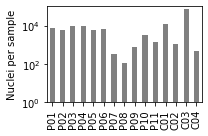

In [10]:
cell_counts = adata.obs['sample_ids'].value_counts()
cell_counts = cell_counts.reindex(sample_order, fill_value=0) 

plt.figure(figsize=(3, 2))  
cell_counts.plot(kind='bar', color='grey')

plt.title('')
plt.xlabel('')
plt.ylabel('Nuclei per sample')
plt.yscale('log') 
plt.ylim((1,100000))
plt.xticks(rotation=90)  
plt.tight_layout()
plt.savefig('./output/NucSeq_Nuclei_Numbers.pdf',dpi=600)
plt.show()

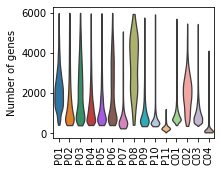

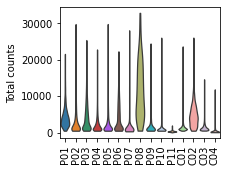

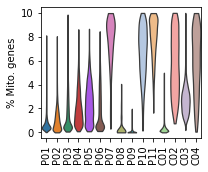

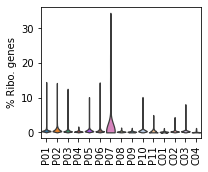

All violin plots saved.


In [11]:
import matplotlib.pyplot as plt
import scanpy as sc

# Directory to save files
output_dir = "./output/"

# Set global figure size
plt.rcParams["figure.figsize"] = (3.5, 2.5)

# Variables to plot
violin_vars = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]

# File names 
output_names = {
    "n_genes_by_counts": "NucSeq_n_genes_by_counts.pdf",
    "total_counts": "NucSeq_total_counts.pdf",
    "pct_counts_mt": "NucSeq_pct_counts_mt.pdf",
    "pct_counts_ribo": "NucSeq_pct_counts_ribo.pdf",
}

# Y-axis labels 
y_labels = {
    "n_genes_by_counts": "Number of genes",
    "total_counts": "Total counts",
    "pct_counts_mt": "% Mito. genes",
    "pct_counts_ribo": "% Ribo. genes",
}

# Loop over variables
for var in violin_vars:
    sc.pl.violin(
        adata,
        [var],
        groupby='sample_ids',
        rotation=90,
        stripplot=False,
        multi_panel=True,
        show=False  
    )
    
    plt.title('')
    plt.xlabel('')
    plt.ylabel(y_labels[var])  # Use custom y-axis label
    #plt.ylabel('Number of nuclei per sample')
    #plt.yscale('log')
    #plt.ylim((1, 100000))
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    output_path = output_dir + output_names[var]
    plt.savefig(output_path, dpi=600, format='pdf')
    plt.show()  

    plt.close()  

print("All violin plots saved.")


## Cell Type Confidence

In [12]:
obs = adata.obs
cell_typescore = obs[['celltype_l1','celltype_l1_prob']]
cell_typescore

Prob_table = cell_typescore.groupby('celltype_l1').agg(['median', 'mean', 'std'])
Prob_table

Prob_table_rounded = Prob_table.round(2)

In [13]:
Prob_table_rounded.columns

MultiIndex([('celltype_l1_prob', 'median'),
            ('celltype_l1_prob',   'mean'),
            ('celltype_l1_prob',    'std')],
           )

In [14]:
Prob_table_rounded=Prob_table_rounded[Prob_table_rounded['celltype_l1_prob', 'median']>=0.6]

In [15]:
# Remove cell-types that have low confidence in annotation
cell_types_to_remove = ['PL','MAST','N']
mask = ~adata.obs['celltype_l1'].isin(cell_types_to_remove)

adata = adata[mask].copy()

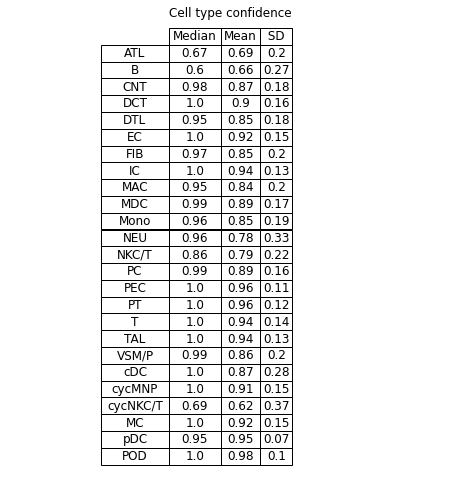

In [16]:
fig, ax = plt.subplots(figsize=(8, len(Prob_table_rounded) / 3))


ax.axis('off')


table = ax.table(
    cellText=Prob_table_rounded.values,
    colLabels=['Median', 'Mean', ' SD '],  # Simplify column labels
    rowLabels=Prob_table_rounded.index,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)  
table.auto_set_column_width(col=list(range(len(Prob_table_rounded.columns) + 1))) 
table.scale(1.4, 1.4)  

for (row, col), cell in table.get_celld().items():
    cell.set_text_props(ha='center')  # Center-align cells
    if row == 0:  # Header row
        cell.set_text_props(fontsize=12)  # Bold header
        #cell.set_facecolor("#f0f0f0")  
    if col == -1:  
        cell.set_text_props()  


plt.title("Cell type confidence", fontsize=12, weight='normal', pad=0)

plt.savefig("./output/NucSeq_CellType_assignment.pdf", bbox_inches='tight')
plt.show()

## Cell Type Markers

In [17]:
adata.layers["scaled"] = sc.pp.scale(adata, max_value=10, copy=True).X.copy()

In [18]:
markers = ["PODXL", "PDGFRB", "CLDN1", "PECAM1", "COL1A1", "LRP2", "VCAM1", "SLC12A3", "CALB1",
           "CASR", "SLC12A1", "UMOD",
           "SH3GL3", "BCAS1",
           "UNC5D","LRRC4C",
           "AQP2", "ATP6V0D2",
           "NRXN1",
           "PTPRC", #"MS4A2", 
           "S100A9", "CD163", "CD14", "FCGR3A", "ITGAX", "CLEC4C", # "CLEC9A", 
           "CD38",# "SDC1", 'CD19', "JCHAIN", 
           "MS4A1", "CD3D", "GZMA"] 

order = ["POD", "MC", "PEC", "EC", "FIB", 'VSM/P', "PT", "DCT", "CNT", "TAL", "ATL", "DTL", "PC", "IC", \
         #"PapE", 
         'NEU',
        #'MAST', 
        # 'N', 
         'MAC', 'Mono',  'MDC','pDC', 
        #'PL', 
         'B',  'T', 
         'cDC', 'cycMNP',  'NKC/T', 'cycNKC/T' ]
         
adata.obs["celltype_l1"] = adata.obs["celltype_l1"].astype("category").cat.reorder_categories(order)

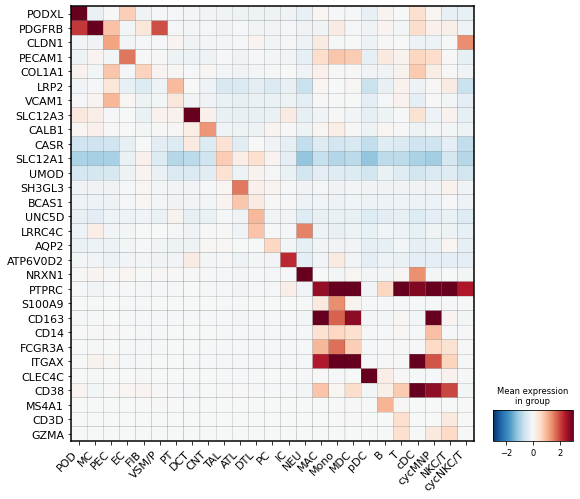

In [19]:
mp = sc.pl.matrixplot(
    adata,
    groupby="celltype_l1",
    var_names=markers,
    dendrogram=False,
    vmin=-3,
    cmap="RdBu_r",
    vmax=3,
    layer="scaled",
    swap_axes=True,  # to swap x and y axes
    return_fig=True,
    figsize=(9, 8),
)

mp.style(edge_color='black', cmap="RdBu_r").savefig("./output/matrixplot_markers_RdBu.png", bbox_inches="tight")

mp.ax_dict["mainplot_ax"].set_xticklabels(
    mp.ax_dict["mainplot_ax"].get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=11,
)
mp.ax_dict["mainplot_ax"].set_yticklabels(
    mp.ax_dict["mainplot_ax"].get_yticklabels(),
    rotation=0,
    ha="right",
    fontsize=11,
)

plt.tight_layout()
plt.savefig("./output/NucSeq_markers_celltypes.pdf", transparent=True)
plt.show()

## Gene Panel

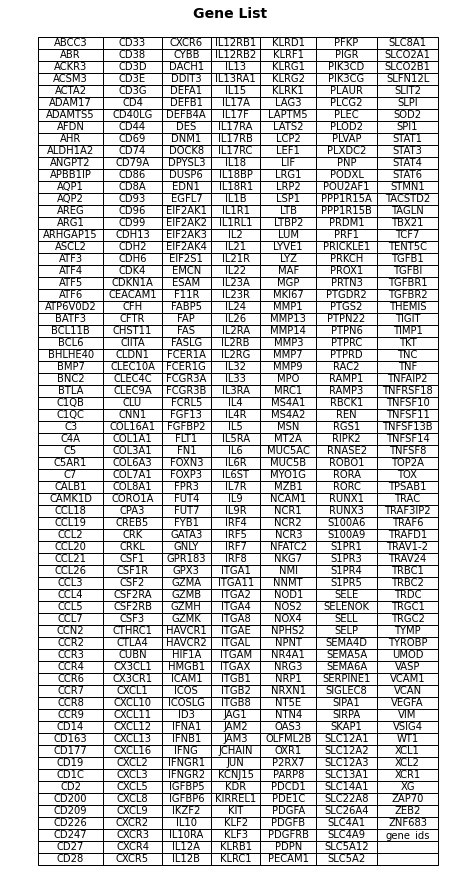

In [20]:
file_path = "../gene_panel.csv"
gene_list = pd.read_csv(file_path, header=None, names=["Gene"])
gene_list = gene_list["Gene"].sort_values().tolist()

num_columns = 7
num_rows = int(np.ceil(len(gene_list) / num_columns))
columns = [gene_list[i * num_rows: (i + 1) * num_rows] for i in range(num_columns)]

max_rows = max(len(col) for col in columns)
columns = [col + [""] * (max_rows - len(col)) for col in columns]

table_data = pd.DataFrame(columns).transpose()

fig, ax = plt.subplots(figsize=(8.27, 11.69))
ax.axis('off')

table = ax.table(
    cellText=table_data.values,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(num_columns)))

fig.suptitle("Gene List", fontsize=14, weight='bold', y=1.03)

plt.savefig("./output/Gene_Panel_Xenium.pdf", bbox_inches='tight')
plt.show()
